# Objects

In [18]:
%load_ext autoreload
%autoreload 2

import crispr as cr
from anndata import AnnData
import scanpy as sc
import copy

col_sample_id = "orig.ident"
kws_harmony = {"plot_convergence": True,
               "random_state": 1618}
kws_process_guide_rna = {"feature_split": "|", "guide_split": "-", 
                         "key_control_patterns": ["CTRL"]}
kws_umap = {"min_dist": 0.3}
kws_umap=kws_umap
kws_init = {"assay": None, "assay_protein": None, 
            "col_gene_symbols": "gene_symbols", 
            "col_cell_type": "majority_voting", 
            "col_sample_id": None, "col_batch": None, 
            "col_perturbed": "perturbation", 
            "col_guide_rna": "feature_call", 
            "col_num_umis": "num_umis", 
            "kws_process_guide_rna": kws_process_guide_rna,
            "col_condition": "target_gene_name", "key_control": "NT", 
            "key_treatment": "KD", "remove_multi_transfected": True}
kws_pp = {"kws_hvg": {"min_mean": 0.0125, "max_mean": 10, 
                      "min_disp": 0.5, "flavor": "cell_ranger"}, 
          "target_sum": 10000.0, "cell_filter_pmt": [0, 15], 
          "cell_filter_ngene": [200, None], "cell_filter_ncounts": [3, 40000], 
          "gene_filter_ncell": [3, None], "regress_out": None, 
          "kws_scale": "z", "kws_umap": kws_umap}
kws_cluster = {"method_cluster": "leiden", "kws_umap": kws_umap, 
               "kws_neighbors": None, 
               "kws_pca": {"n_comps": None, "use_highly_variable": True}, 
               "kws_cluster": {"resolution": 0.5}}

file_path = {'HH03': {'directory': 'data/crispr-screening/HH06'}, 
             'CR4': {'directory': 'data/crispr-screening/HH-Hu-CR4'},
             'CR5': {'directory': 'data/crispr-screening/HH-Hu-CR5'}}



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Integrated Object

We first have to create preprocessed and clustered individual objects, then integrate them with Harmony.

## Integrate Data

If `kws_pp` and/or `kws_cluster` = None, then preprocessing and/or clustering, respectively, will not be performed on individual objects.



<<< INITIALIZING CRISPR CLASS OBJECT >>>


<<< LOADING PROTOSPACER METADATA >>>


Cell Counts: Raw

19226


Gene Counts: Raw



<<<PERFORMING gRNA PROCESSING AND FILTERING>>>

                    num_features  \
AAACCCAAGAAGAACG-1           NaN   
AAACCCAAGCTCCCTT-1           NaN   
AAACCCAAGGCTCCCA-1           2.0   
AAACCCAAGGGCCTCT-1           NaN   
AAACCCACAGATCACT-1           7.0   
...                          ...   
TTTGTTGTCCGACAGC-1           NaN   
TTTGTTGTCGGAAGGT-1           3.0   
TTTGTTGTCTACCACC-1           NaN   
TTTGTTGTCTAGCAAC-1           2.0   
TTTGTTGTCTAGGCCG-1           2.0   

                                                feature_call_original  \
AAACCCAAGAAGAACG-1                                                NaN   
AAACCCAAGCTCCCTT-1                                                NaN   
AAACCCAAGGCTCCCA-1                          NEG_CTRL-1-1|NEG_CTRL-3-2   
AAACCCAAGGGCCTCT-1                                                NaN   
AAACCCACAGATCACT-1  LGAL

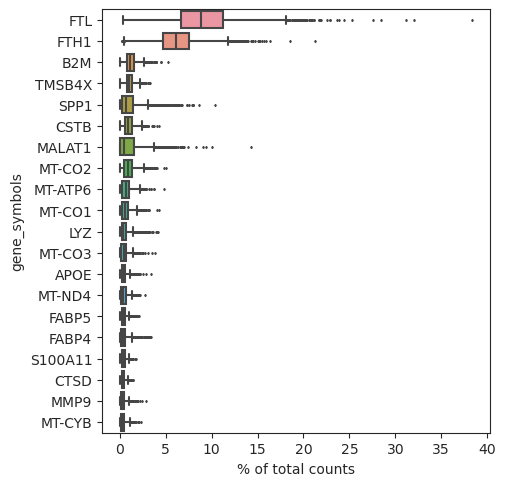


	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




... storing 'feature_call_original' as categorical
... storing 'num_umis_original' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'target_gene_name' as categorical
... storing 'guide_split' as categorical
... storing 'feature_types' as categorical


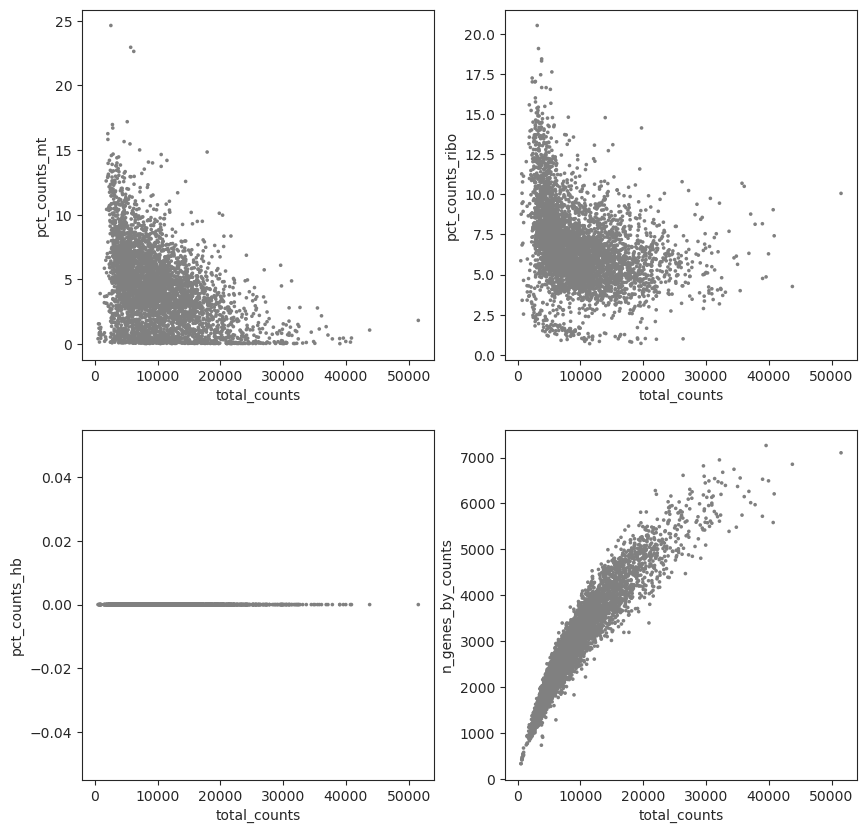

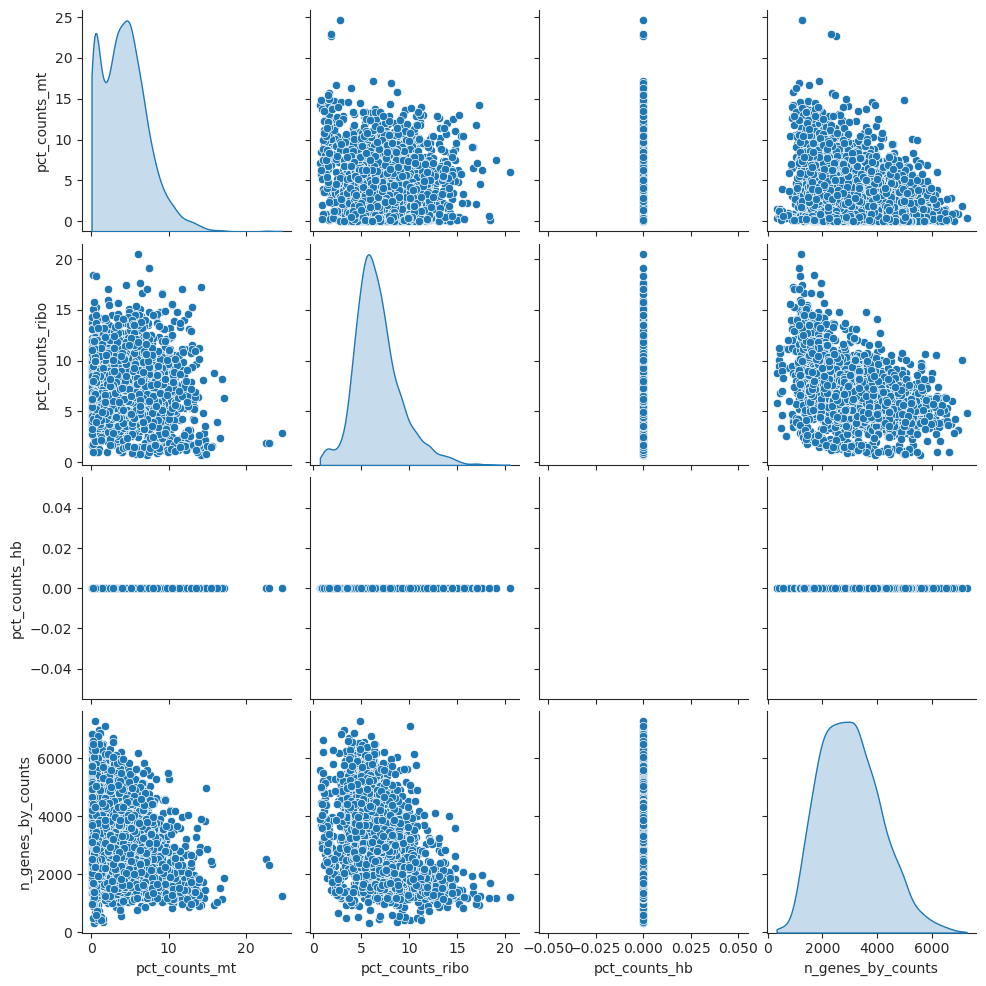

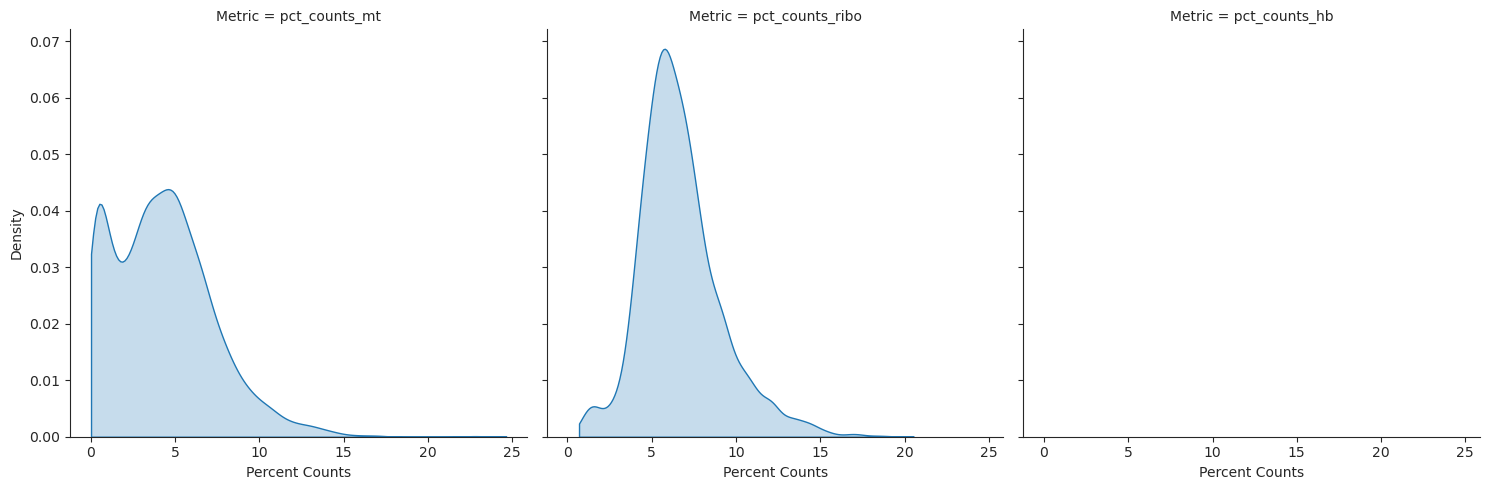

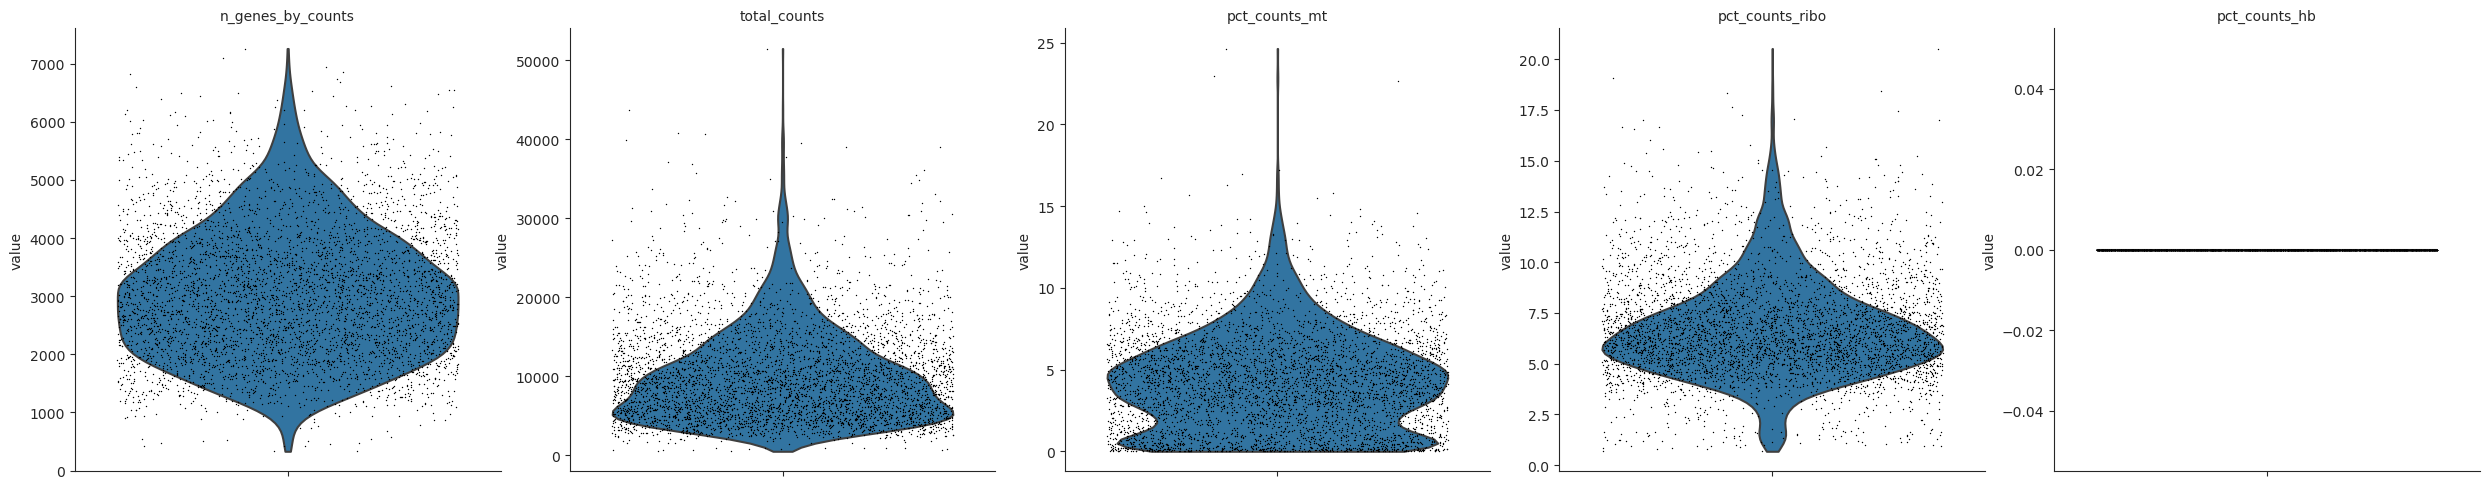

       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       36549.000000  36549.000000       36549.000000   
mean          362.621823      0.274698           0.113266   
std           763.060715      6.093418           0.302049   
min             0.000000      0.000000           0.000000   
25%             0.000000      0.000000           0.000000   
50%             6.000000      0.001370           0.001370   
75%           296.000000      0.074692           0.072034   
max          4378.000000    924.271362           6.830087   

       pct_dropout_by_counts  total_counts  log1p_total_counts  
count           36549.000000  3.654900e+04        36549.000000  
mean               91.717181  1.202626e+03            2.984419  
std                17.429436  2.667698e+04            3.042567  
min                 0.000000  0.000000e+00            0.000000  
25%                93.238922  0.000000e+00            0.000000  
50%                99.862951  6.000000e+00            1.9459

In [21]:
adata = cr.pp.create_object_multi(
    file_path, kws_init=kws_init, kws_pp=kws_pp, kws_cluster=kws_cluster, 
    kws_harmony=kws_harmony)  # create integrated AnnData object
kws_init_new = copy.deepcopy(kws_init)
kws_init_new["kws_process_guide_rna"] = None  # don't need any more
# kws_init_new["col_sample_id"] = col_sample_id
# kws_init_new["col_batch"] = col_sample_id

## Create Overall Object

In [ ]:
self = cr.Crispr(adata, **{**kws_init_new, 
                           **{"col_sample_id": "unique.idents", 
                              "col_batch": "unique.idents"}}
                 )  # pass integrated object to Crispr class
del(adata)  # object now in `self`

# Clustering & Annotations

Clustering was conducted in the individual objects in `cr.pp.create_object_multi()`, but we want to re-do QC and clustering in the overall sample.

## Clustering

We need to have `kws_pca=False` so that the Harmony-adjusted PCA created during integration (rather than a newly-calculated one) will be used.

In [ ]:
self.cluster(**{**kws_cluster, "kws_pca": False}, layer="log1p")
degs = self.find_markers(n_genes=10, method="wilcoxon", key_reference="rest")
degs[0]  # marker data; degs[1] for figures

## CellTypist

Annotate cell types.

In [ ]:
preds, f_ct = self.annotate_clusters(model="COVID19_HumanChallenge_Blood.pkl")
self.rna.obs

# Plots

In [ ]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
clus = list(self.rna.obs[cct].sample(2))  # clusters to circle
figs = self.plot(genes=36, 
                 kws_qc=True,
                 col_cell_type=cct,
                 layers="all",  # also plot "scaled" layer, for instance
                 kws_gex_violin=dict(scale="area", height=10),
                 kws_clustering=dict(col_cell_type=cct))

# Analyses

Perform perturbation-specific analyses.

## Augur

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
_ = self.run_augur(
    col_cell_type=cct, 
    # ^ will be label in self._columns by default, but can override here
    col_perturbed=self._columns["col_perturbed"], 
    # ^ will be this by default if unspecified, but can override here
    key_treatment=self._keys["key_treatment"],  
    # ^ will be this by default if unspecified, but can override here
    select_variance_features=True,  # filter by highly variable genes
    classifier="random_forest_classifier", n_folds=3, augur_mode="default", 
    kws_umap=kws_umap, subsample_size=5, kws_augur_predict=dict(span=0.7))

## Mixscape

In [ ]:
figs_mixscape = self.run_mixscape(
    col_split_by="orig.ident", col_cell_type=cct, target_gene_idents=True)

# Distance

Investigate distance metrics.

In [ ]:
kws_plot = dict(figsize=(15, 15), robust=True)  # heatmap keywords
fig_dist_w = self.compute_distance(distance_type="edistance", method="X_pca",
                                   kws_plot=kws_plot)
fig_dist_e = self.compute_distance(distance_type="mmd", method="X_pca",
                                   kws_plot=kws_plot)